In [ ]:
import r3.adapters as adapters
import r3.schema as schema

X_columns = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.DNA_ug_mL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.dsRNA_percent.value]

experimental_conditions, responses = adapters.DataPipelineAdapter("dsrna_lhs").get(
    X_columns=X_columns,
    y_columns=y_columns,
)

experimental_conditions

📊 Extracted DataFrame with columns ['NTPs [M]', 'T7RNAP [units/uL]', 'DNA [µg/mL]', 'Mg2+ [M]', 'Reaction Time [min]'] and ['dsRNA [%]']
X shape: (80, 5), y shape: (80, 1)
X head:
   NTPs [M]  T7RNAP [units/uL]  DNA [µg/mL]  Mg2+ [M]  Reaction Time [min]
0  0.002237         109.285882    49.217245  0.013340            15.975448
1  0.011370         102.000948    92.963862  0.045625           205.895482
2  0.013120         301.864929    91.286401  0.034906            89.767563
3  0.012105         277.820595    61.743404  0.026270            44.601100
4  0.012105         277.820595    61.743404  0.026270            44.601100
y head:
   dsRNA [%]
0   2.130682
1   0.411220
2   0.035209
3   0.422909
4   0.150595


,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min]
0,0.002237,109.285882,49.217245,0.013340,15.975448
1,0.011370,102.000948,92.963862,0.045625,205.895482
2,0.013120,301.864929,91.286401,0.034906,89.767563
3,0.012105,277.820595,61.743404,0.026270,44.601100
4,0.012105,277.820595,61.743404,0.026270,44.601100
...,...,...,...,...,...
75,0.014942,359.010522,54.952946,0.054598,143.752553
76,0.002423,148.507894,81.381476,0.009032,188.421396
77,0.008220,337.662327,74.517838,0.028639,73.872966
78,0.011866,287.674023,69.082018,0.067321,92.660776


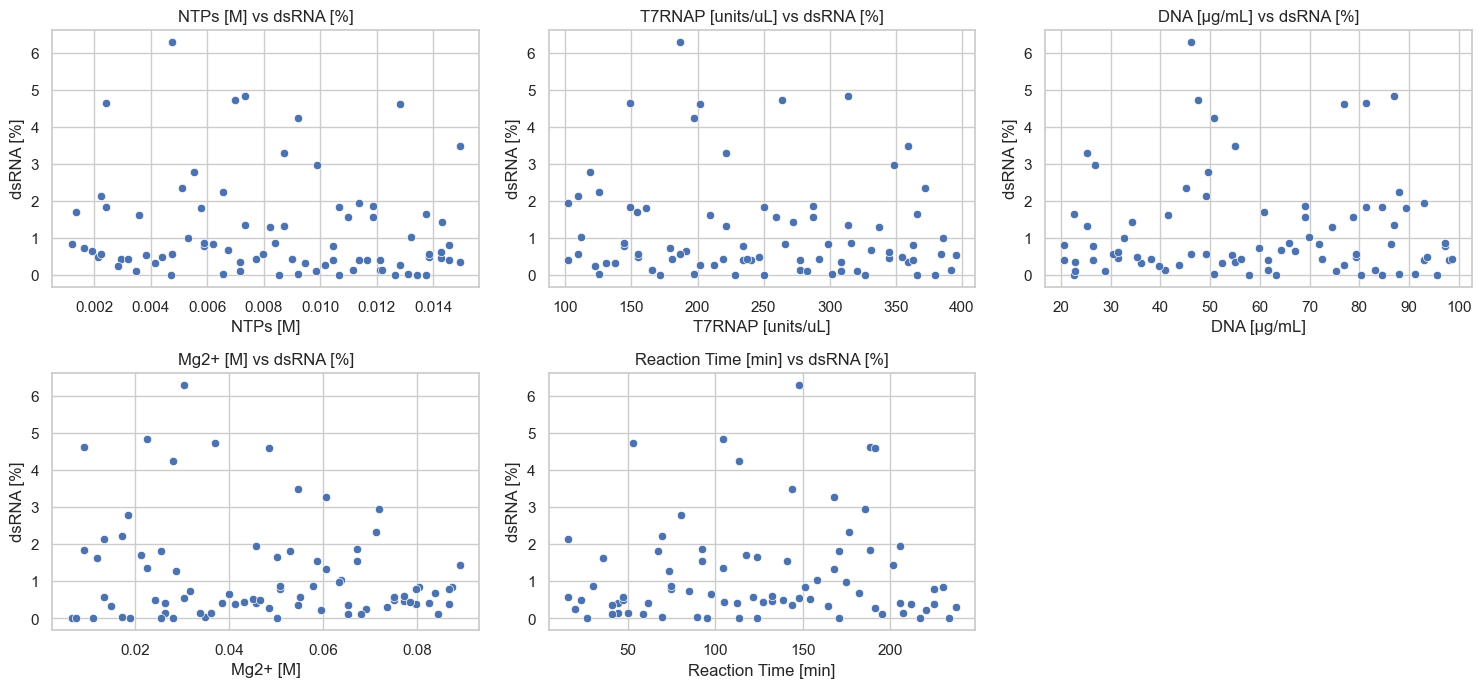

In [4]:
# plot the experimental conditions against the response in a grid
import matplotlib.pyplot as plt
import seaborn as sns

experimental_data = experimental_conditions.copy()
experimental_data[y_columns[0]] = responses
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_columns):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=experimental_data, x=col, y=y_columns[0])
    plt.title(f"{col} vs {y_columns[0]}")
    plt.xlabel(col)
    plt.ylabel(y_columns[0])
plt.tight_layout()

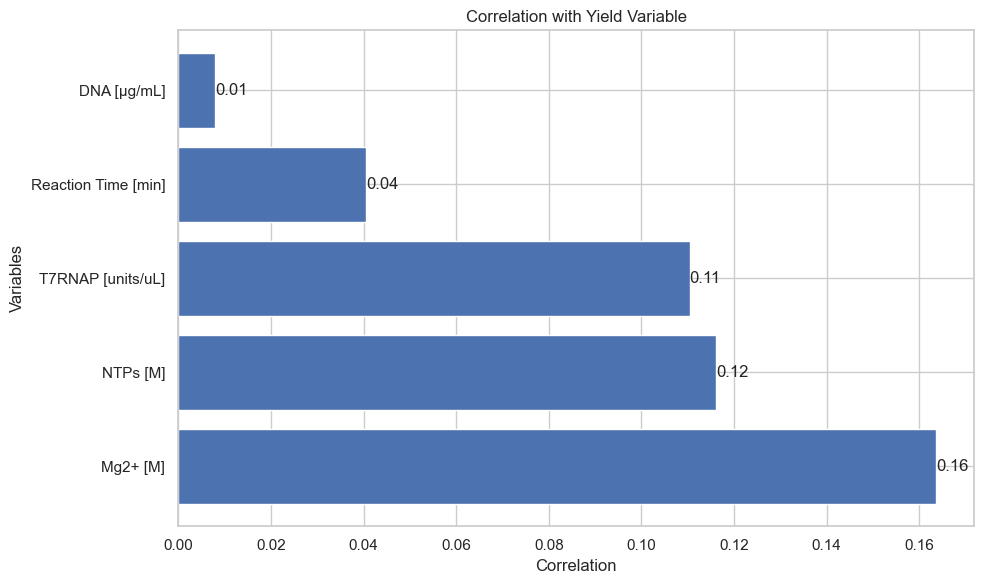

In [5]:
# Calculate the correlation coefficients with the yield variable
corr_matrix = experimental_data.corr()
correlations = corr_matrix[y_columns[0]].drop(y_columns[0])

# Sort the correlations in descending order
correlations = correlations.abs().sort_values(ascending=False)

# Create a horizontal bar chart of the correlations
plt.figure(figsize=(10, 6))
plt.barh(correlations.index, correlations.values)
plt.xlabel("Correlation")
plt.ylabel("Variables")
plt.title("Correlation with Yield Variable")
plt.tight_layout()
# add correlation values to the bars
for index, value in enumerate(correlations):
    plt.text(value, index, f"{value:.2f}", va="center")

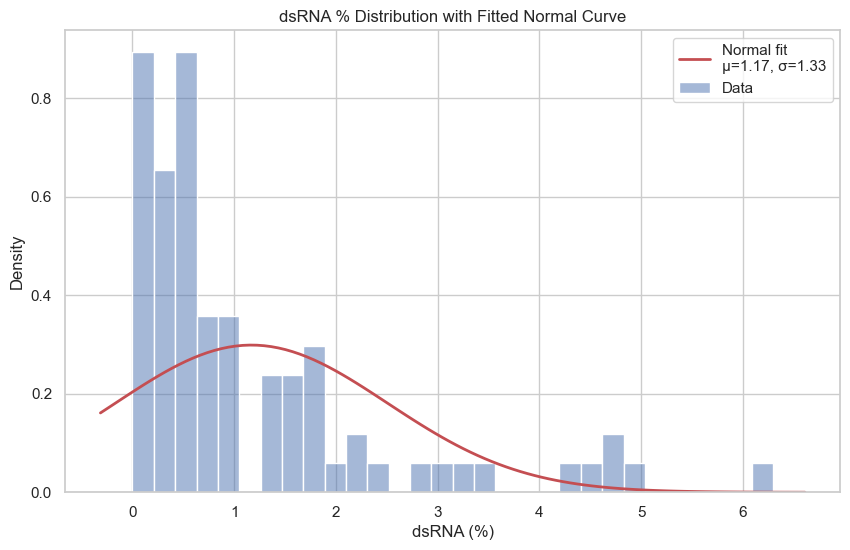

In [11]:
from scipy import stats
import numpy as np

# Fit a normal distribution
mu, std = stats.norm.fit(responses.values)

# Plot histogram and fitted PDF
plt.figure(figsize=(10, 6))
sns.histplot(
    responses.values, bins=30, kde=False, stat="density", color="skyblue", label="Data"
)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r", linewidth=2, label=f"Normal fit\nμ={mu:.2f}, σ={std:.2f}")
plt.title("dsRNA % Distribution with Fitted Normal Curve")
plt.xlabel("dsRNA (%)")
plt.ylabel("Density")
plt.legend()
plt.show()

FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'gamma' requires that 0 < (x - loc)/scale  < inf for each x in `data`.

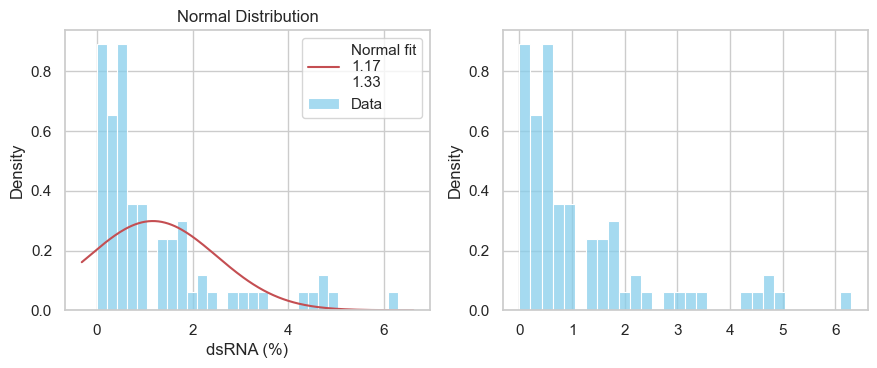

In [ ]:
rna_yield = responses[y_columns[0]].dropna().values

# List of distributions to fit (Beta removed)
distributions = {
    "Normal": stats.norm,
    "Log-Normal": stats.lognorm,
    "Gamma": stats.gamma,
    "Exponential": stats.expon,
    "Negative Binomial": stats.nbinom,
    "Weibull": stats.weibull_min,
}

plt.figure(figsize=(16, 8))
for i, (name, dist) in enumerate(distributions.items(), 1):
    plt.subplot(2, 3, i)
    sns.histplot(
        rna_yield, bins=30, kde=False, stat="density", color="skyblue", label="Data"
    )
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 200)
    if name == "Log-Normal":
        shape, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, shape, loc, scale)
        label = f"shape={shape:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    elif name == "Gamma":
        a, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, a, loc, scale)
        label = f"a={a:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    elif name == "Negative Binomial":
        data_nb = np.round(rna_yield - rna_yield.min()).astype(int)
        data_nb = data_nb[data_nb >= 0]
        mean_nb = np.mean(data_nb)
        var_nb = np.var(data_nb)
        if var_nb > mean_nb:
            p = mean_nb / var_nb
            n = mean_nb * p / (1 - p)
            x_nb = np.arange(data_nb.min(), data_nb.max() + 1)
            pmf = stats.nbinom.pmf(x_nb, n, p)
            plt.stem(
                x_nb + rna_yield.min(),
                pmf,
                linefmt="r-",
                markerfmt="ro",
                basefmt=" ",
                label=f"n={n:.2f}\np={p:.2f}",
            )
            label = f"n={n:.2f}\np={p:.2f}"
        else:
            label = "var <= mean, NB not valid"
        pdf = None
    elif name == "Weibull":
        c, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, c, loc, scale)
        label = f"c={c:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    else:
        params = dist.fit(rna_yield)
        pdf = dist.pdf(x, *params)
        label = "\n".join([f"{p:.2f}" for p in params])
    if name != "Negative Binomial":
        plt.plot(x, pdf, "r", label=f"{name} fit\n{label}")
    plt.title(f"{name} Distribution")
    plt.xlabel("dsRNA (%)")
    plt.ylabel("Density")
    plt.legend()
plt.tight_layout()
plt.show()

# Statistical tests
print("Normality Tests:")
shapiro_stat, shapiro_p = stats.shapiro(rna_yield)
print(f"Shapiro-Wilk: W={shapiro_stat:.3f}, p={shapiro_p:.3g}")
ad_result = stats.anderson(rna_yield, dist="norm")
print(
    f"Anderson-Darling: statistic={ad_result.statistic:.3f}, critical_values={ad_result.critical_values}"
)

print("\nGoodness-of-fit (Kolmogorov-Smirnov) for each distribution:")
for name, dist in distributions.items():
    try:
        if name == "Log-Normal":
            params = dist.fit(rna_yield, floc=0)
            d_stat, p_val = stats.kstest(rna_yield, "lognorm", args=params)
        elif name == "Negative Binomial":
            data_nb = np.round(rna_yield - rna_yield.min()).astype(int)
            data_nb = data_nb[data_nb >= 0]
            mean_nb = np.mean(data_nb)
            var_nb = np.var(data_nb)
            if var_nb > mean_nb:
                p = mean_nb / var_nb
                n = mean_nb * p / (1 - p)
                d_stat, p_val = stats.kstest(data_nb, "nbinom", args=(n, p, 0))
                print(f"{name}: KS statistic={d_stat:.3f}, p={p_val:.3g}")
            else:
                print(f"{name}: KS test not valid (var <= mean)")
            continue
        elif name == "Weibull":
            params = dist.fit(rna_yield, floc=0)
            d_stat, p_val = stats.kstest(rna_yield, "weibull_min", args=params)
        elif name == "Normal":
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, "norm", args=params)
        elif name == "Exponential":
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, "expon", args=params)
        else:
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, name.lower(), args=params)
        print(f"{name}: KS statistic={d_stat:.3f}, p={p_val:.3g}")
    except Exception as e:
        print(f"{name}: KS test not available ({e})")

Root Mean squared error on training set: 1.3233723590128565
R-squared score on training: 0.017313048978928713


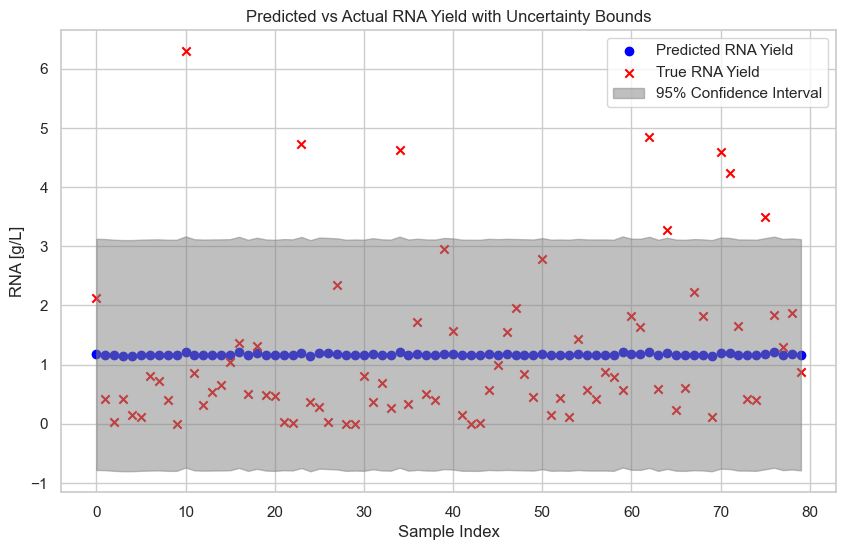

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

X_train, y_train = experimental_conditions[X_columns], responses[y_columns[0]]

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

df = pd.DataFrame(X_train_scaled, columns=X_columns)
df[y_columns[0]] = y_train_scaled

matern_gp_model = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2))
    * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5)
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=100,
    random_state=42,
)
matern_gp_model.fit(X_train_scaled, y_train_scaled)

# Training set predictions
pre_scaled_pred = matern_gp_model.predict(X_train_scaled)
predictions = scaler_y.inverse_transform(pre_scaled_pred.reshape(-1, 1)).flatten()
print(
    "Root Mean squared error on training set:",
    np.sqrt(mean_squared_error(y_train, predictions)),
)
print(
    "R-squared score on training:",
    matern_gp_model.score(X_train_scaled, y_train_scaled),
)

x_axis = np.arange(len(X_train))
plt.figure(figsize=(10, 6))
plt.scatter(
    x_axis,
    predictions,
    label="Predicted RNA Yield",
    color="blue",
    marker="o",
)
plt.scatter(x_axis, y_train, label="True RNA Yield", color="red", marker="x")
plt.fill_between(
    x_axis,
    predictions - 1.96 * np.sqrt(matern_gp_model.kernel_.k2.noise_level),
    predictions + 1.96 * np.sqrt(matern_gp_model.kernel_.k2.noise_level),
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Predicted vs Actual RNA Yield with Uncertainty Bounds")
plt.legend()

In [23]:
import plotly.graph_objects as go
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Use descriptive variable names
anova_data = pd.DataFrame(
    data={
        "dsRNA": responses.values.ravel(),
        "NTP_M": experimental_conditions[X_columns[0]].values.ravel(),
        "T7RNAP_u_uL": experimental_conditions[X_columns[1]].values.ravel(),
        "DNA_ug_mL": experimental_conditions[X_columns[2]].values.ravel(),
        "Mg2_M": experimental_conditions[X_columns[3]].values.ravel(),
        "TIME_min": experimental_conditions[X_columns[4]].values.ravel(),
    }
)

# Build formula with all main effects and all interaction effects (up to 5-way)
formula = "dsRNA ~ NTP_M + T7RNAP_u_uL + DNA_ug_mL + Mg2_M + TIME_min + NTP_M * Mg2_M + T7RNAP_u_uL * NTP_M + T7RNAP_u_uL * DNA_ug_mL + T7RNAP_u_uL * Mg2_M + T7RNAP_u_uL * TIME_min + DNA_ug_mL * Mg2_M + DNA_ug_mL * TIME_min + Mg2_M * TIME_min + NTP_M * T7RNAP_u_uL * DNA_ug_mL + NTP_M * T7RNAP_u_uL * Mg2_M + NTP_M * T7RNAP_u_uL * TIME_min + NTP_M * DNA_ug_mL * Mg2_M + NTP_M * DNA_ug_mL * TIME_min + NTP_M * Mg2_M * TIME_min + T7RNAP_u_uL * DNA_ug_mL * Mg2_M + T7RNAP_u_uL * DNA_ug_mL * TIME_min + T7RNAP_u_uL * Mg2_M * TIME_min + DNA_ug_mL * Mg2_M * TIME_min"

lm = ols(formula=formula, data=anova_data).fit()

# Show full model summary
print(lm.summary())

# ANOVA table
anova_results = anova_lm(lm)
print("\nANOVA Table:")
print(anova_results)

# Extract p-values and F-statistics
anova_results = anova_results.reset_index().rename(columns={"index": "Term"})
anova_results["Significant"] = anova_results["PR(>F)"] < 0.05

# Plot p-values for all terms
fig = go.Figure(
    data=[
        go.Bar(
            y=anova_results["Term"],
            x=anova_results["PR(>F)"],
            orientation="h",
            marker_color=[
                "crimson" if sig else "steelblue"
                for sig in anova_results["Significant"]
            ],
            text=[
                f"F={fval:.2f}, p={pval:.3g}"
                for fval, pval in zip(anova_results["F"], anova_results["PR(>F)"])
            ],
            hoverinfo="text",
        )
    ]
)

fig.add_vline(
    x=0.05,
    line_width=3,
    line_dash="dash",
    line_color="red",
    annotation_text="p=0.05",
    annotation_position="top right",
)
fig.update_xaxes(title="p-value", range=[0, 1])
fig.update_yaxes(title="Model Term")
fig.update_layout(
    barmode="stack",
    title_text="ANOVA Model Term p-values (red = significant, p < 0.05)",
    yaxis={"categoryorder": "total ascending"},
    height=800,
)

                            OLS Regression Results                            
Dep. Variable:                  dsRNA   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                 -0.152
Method:                 Least Squares   F-statistic:                    0.5830
Date:                Fri, 22 Aug 2025   Prob (F-statistic):              0.929
Time:                        09:39:49   Log-Likelihood:                -127.07
No. Observations:                  80   AIC:                             306.1
Df Residuals:                      54   BIC:                             368.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   